In [1]:
%matplotlib inline
from q_function import Q
import numpy as np
import matplotlib.pyplot as plt


## Define the grid and actions

Let $S$ be the grid and $A$ be a set of actions.
Our goal is to train a function $Q:S\times A\to R$, that rates state action pairs such that we can use it to always find the best action for every state we're in.

The grid consists of $10 \times 10$ cells, whereall but four are 'dangerous' and the other four are 'safe'.

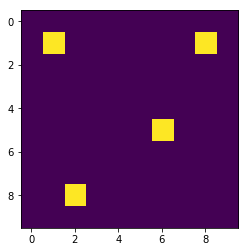

In [2]:
grid = np.ones((10, 10)) * -1

grid[1, 1] = 1
grid[1, 8] = 1
grid[5, 6] = 1
grid[8, 2] = 1

plt.imshow(grid)

In [3]:
def check(acfunc):
    def wrapper(arg):
        retval = acfunc(arg)
        for ind in range(2):
            if retval[ind] < 0:
                retval[ind] = 0
            if retval[ind] > 9:
                retval[ind] = 9
        return retval
    return wrapper

up = lambda state : state + np.array([-1, 0])
down = lambda state : state + np.array([1, 0])
left = lambda state : state + np.array([0, -1])
right = lambda state : state + np.array([0, 1])
stand = lambda state : state

actions = {'up' : check(up), 
           'down' : check(down), 
           'left' : check(left), 
           'right': check(right), 
           'stand' : stand}

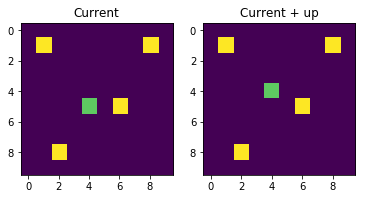

In [4]:
cur = np.array([5, 4])
grid[cur[0], cur[1]] = .5

plt.subplot(1, 2, 1)
plt.title('Current')
plt.imshow(grid)
grid[cur[0], cur[1]] = -1

nex = actions['up'](cur)
grid[nex[0], nex[1]] = .5

plt.subplot(1, 2, 2)
plt.title('Current + up')
plt.imshow(grid)
grid[nex[0], nex[1]] = -1



## Define the policy $\pi(s)$, a complete run and the loss

The policy decides given a state what the appropriate action should be:

$\pi(s) \mapsto a$

$\DeclareMathOperator*{\argmax}{argmax}$
To decide the appropriate action it uses the Q function to estimate the reward:

$\pi(s) := \argmax_a Q(s, a)$

In our experiment the agent starts at an initial position $s_0$ and a run consists of him doing ten actions.
The run is then defined as the sum of the rewards from those ten actions:


$R(Q, s_0) = \sum_{t=0}^N reward(s_t, \pi(s_t))$


The loss is defined as the sum of runs for all possible states:

$L(Q) = \sum_{s\in S} R(Q, s)$


In [5]:
q = Q()
states = np.array([np.array([x, y]) for x in range(10) for y in range(10)])

def pi(state):
    """ state -> action, Q(state, action)   """
    expected_values = np.array([q(state, action) for action in actions.keys()])
    argmax = np.argmax(expected_values)
    return list(actions.keys())[argmax], expected_values[argmax]

def run(init_state, train=True, lr=.1, gamma=.9):
    """ state_0 -> sigma_0^N Q(state_i, action_i)"""
    state = init_state
    G = 0
    for step in range(10):
        next_state = actions[pi(state)[0]](state)
        reward = grid[next_state[0], next_state[1]]
        G += reward
        if train:
            action = pi(state)[0]
            qval = (1-lr) * q(state, action) + lr * (reward + gamma * pi(next_state)[1])
            q.update(state, action, qval)
        state = next_state
    return G
                
def loss():
    """ sigma_{state in possibleStates} run(state)"""
    total = 0
    for init_state in states:
        total += run(init_state, train=False)
    return -total

## Train the Q function

We train the Q function by performing thousend runs and updating its state, action ratings using this formula:
https://en.wikipedia.org/wiki/Q-learning

$$Q(s_t, a_t) \leftarrow (1-\alpha)\cdot Q(s_t, a_t) + \alpha \left(r_{t+1} + \gamma \cdot \max_a Q(s_{t+1}, a)\right)$$

The initial state for the runs are choosen at random.
We also compute the loss every ten runs in order to visualize the training progress.

In [33]:
nofsteps = 1000
lossstep = 10

iters = np.array([])
losses = np.array([])

q.reset()
for iteration in range(nofsteps):
    init_state = states[np.random.randint(0 , len(states))]
    run(init_state)
    if iteration % lossstep == 0:
        iters = np.append(iters, [iteration])
        losses = np.append(losses, [loss()])

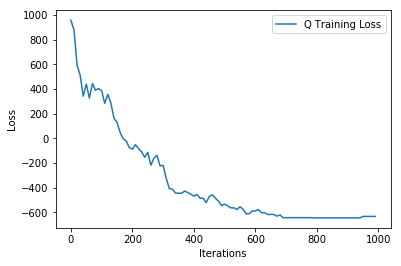

In [34]:
plt.plot(iters, losses, label='Q Training Loss')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Loss')

## Result

We trained our Q function until the loss appeared to be in its minimum.
As a final check we define an initial state in the bottom right corner.
We know that the optimal behaviour would be to go to the next safe zone in five steps and then stay there.
Let's see if our Q function agrees.

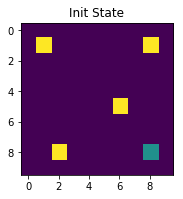

In [46]:
plt.subplot(1, 2, 1)
ini = np.array([8, 8])
plt.title('Init State')
grid[ini[0], ini[1]] = 0
plt.imshow(grid)
grid[ini[0], ini[1]] = -1


In [48]:
state = ini
for step in range(10):
    print(pi(state)[0])
    state = actions[pi(state)[0]](state)

left
up
up
left
up
stand
stand
stand
stand
stand
